In [7]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  

ImportError: Traceback (most recent call last):
  File "c:\Users\manne\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [8]:
data_dir = r"C:\vs code\AI&ES\archive_road"

# Load the training CSV file
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

# Number of unique classes (should be 43)
nb_classes = train_csv["ClassId"].nunique()
print("Number of classes:", nb_classes)

classes = {
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)',
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection',
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
    17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right',
    21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right',
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing',
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing',
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead',
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right',
    39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}

# Create a mapping: classid -> class name
class_names_label = classes

# Example lookup
print("Class 2 means:", class_names_label[2])

Number of classes: 43
Class 2 means: Speed limit (50km/h)


In [9]:
sizes = set()

for i, row in tqdm(train_csv.iterrows(), total=len(train_csv)):
    img_path = os.path.join(data_dir, row["Path"])
    image = cv2.imread(img_path)
    if image is not None:
        sizes.add(image.shape[:2])  # (height, width)

print("Unique image sizes in Train:", sizes)
print("Number of unique sizes:", len(sizes))

100%|██████████| 39209/39209 [05:54<00:00, 110.49it/s]

Unique image sizes in Train: {(107, 95), (59, 55), (118, 104), (70, 64), (89, 77), (136, 158), (29, 32), (48, 45), (40, 41), (100, 92), (92, 88), (63, 61), (148, 168), (41, 42), (73, 74), (33, 38), (52, 51), (44, 47), (104, 98), (116, 72), (194, 220), (74, 75), (93, 88), (106, 107), (85, 84), (55, 61), (136, 135), (96, 99), (88, 95), (47, 57), (107, 108), (147, 144), (99, 104), (59, 68), (118, 117), (158, 190), (70, 77), (170, 164), (77, 85), (69, 81), (148, 145), (100, 105), (113, 124), (140, 141), (92, 101), (132, 137), (110, 118), (81, 91), (125, 134), (51, 68), (95, 111), (114, 124), (47, 34), (59, 45), (76, 97), (96, 112), (136, 148), (128, 144), (40, 31), (140, 118), (69, 94), (62, 55), (121, 141), (41, 32), (54, 51), (81, 68), (33, 28), (44, 37), (144, 124), (51, 45), (43, 41), (103, 92), (95, 88), (74, 65), (66, 61), (36, 38), (55, 51), (28, 34), (96, 89), (47, 47), (88, 85), (128, 121), (136, 125), (107, 98), (99, 94), (118, 107), (58, 62), (157, 184), (77, 75), (50, 58), (69,

In [ ]:
IMAGE_SIZE = (64, 64)
def load_data(df, base_dir):
    images = []
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(base_dir, row["Path"])
        label = row["ClassId"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        # Normalization
        image = image.astype("float32") / 255.0

        images.append(image)
        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")
    return images, labels


test_csv  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_images, train_labels = load_data(train_csv, data_dir)
test_images, test_labels = load_data(test_csv, data_dir)

100%|██████████| 12630/12630 [01:57<00:00, 107.64it/s]


In [11]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [12]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples:", n_train)
print("Number of testing examples:", n_test)
print("Each image is of size:", IMAGE_SIZE)

Number of training examples: 39209
Number of testing examples: 12630
Each image is of size: (64, 64)


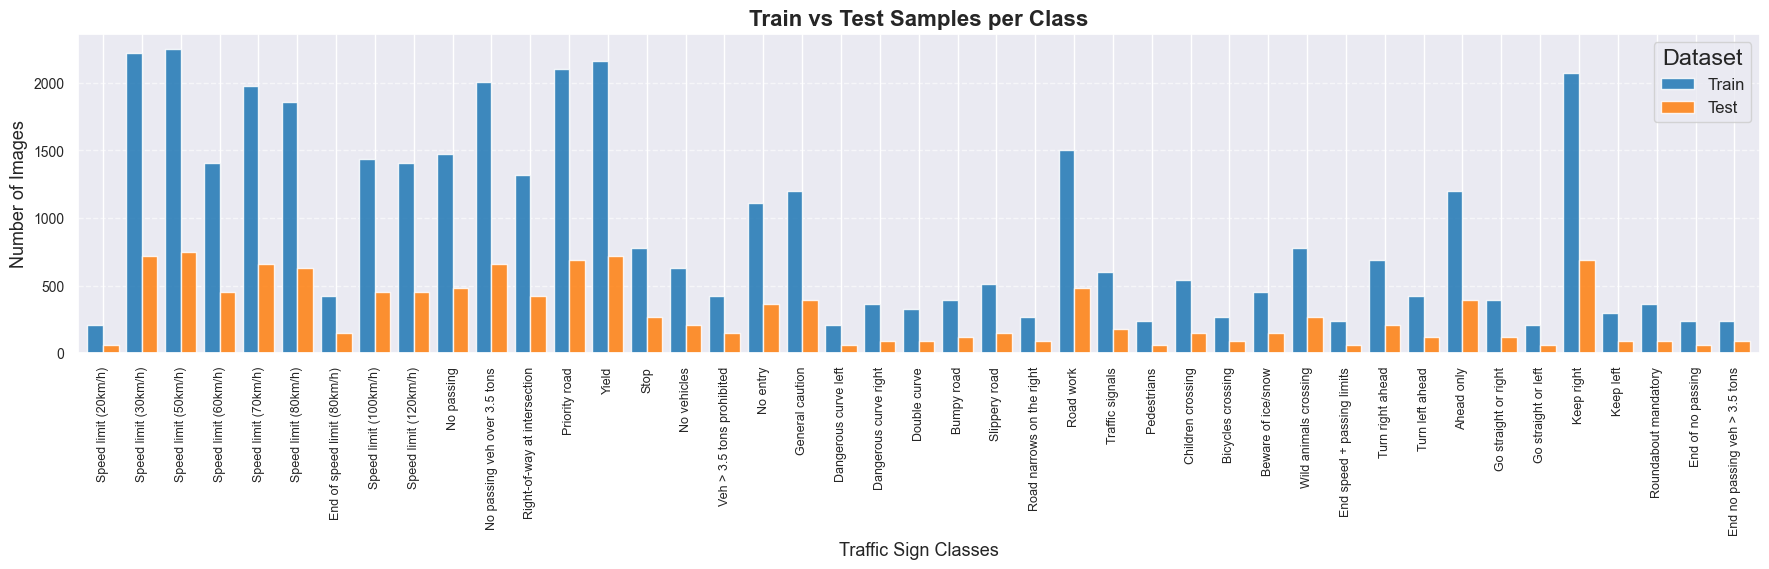

In [15]:
train_ids, train_counts = np.unique(train_labels, return_counts=True)
test_ids, test_counts = np.unique(test_labels, return_counts=True)

df = pd.DataFrame({
    'Train': pd.Series(train_counts, index=train_ids),
    'Test': pd.Series(test_counts, index=test_ids)
})

# Add class names
df.index = [classes[i] for i in df.index]

# Plot
ax = df.plot.bar(figsize=(18,6), width=0.8, alpha=0.85, color=["#1f77b4", "#ff7f0e"])

plt.title("Train vs Test Samples per Class", fontsize=16, fontweight="bold")
plt.ylabel("Number of Images", fontsize=13)
plt.xlabel("Traffic Sign Classes", fontsize=13)
plt.xticks(rotation=90, fontsize=9)   # Rotate x labels for readability
plt.yticks(fontsize=10)

plt.legend(title="Dataset", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [14]:
def display_random_image(classes, images, labels):
    """
        Display a random image from the images array and its corresponding label.
    """
    index = np.random.randint(images.shape[0])
    
    plt.figure(figsize=(3,3))
    plt.imshow(images[index])   
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index} : {classes[labels[index]]}', fontsize=12)
    plt.show()


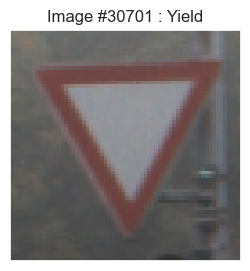

In [16]:
display_random_image(classes, train_images, train_labels)

In [17]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])  # RGB image, no cmap
        plt.xlabel(classes[labels[i]])
    plt.show()

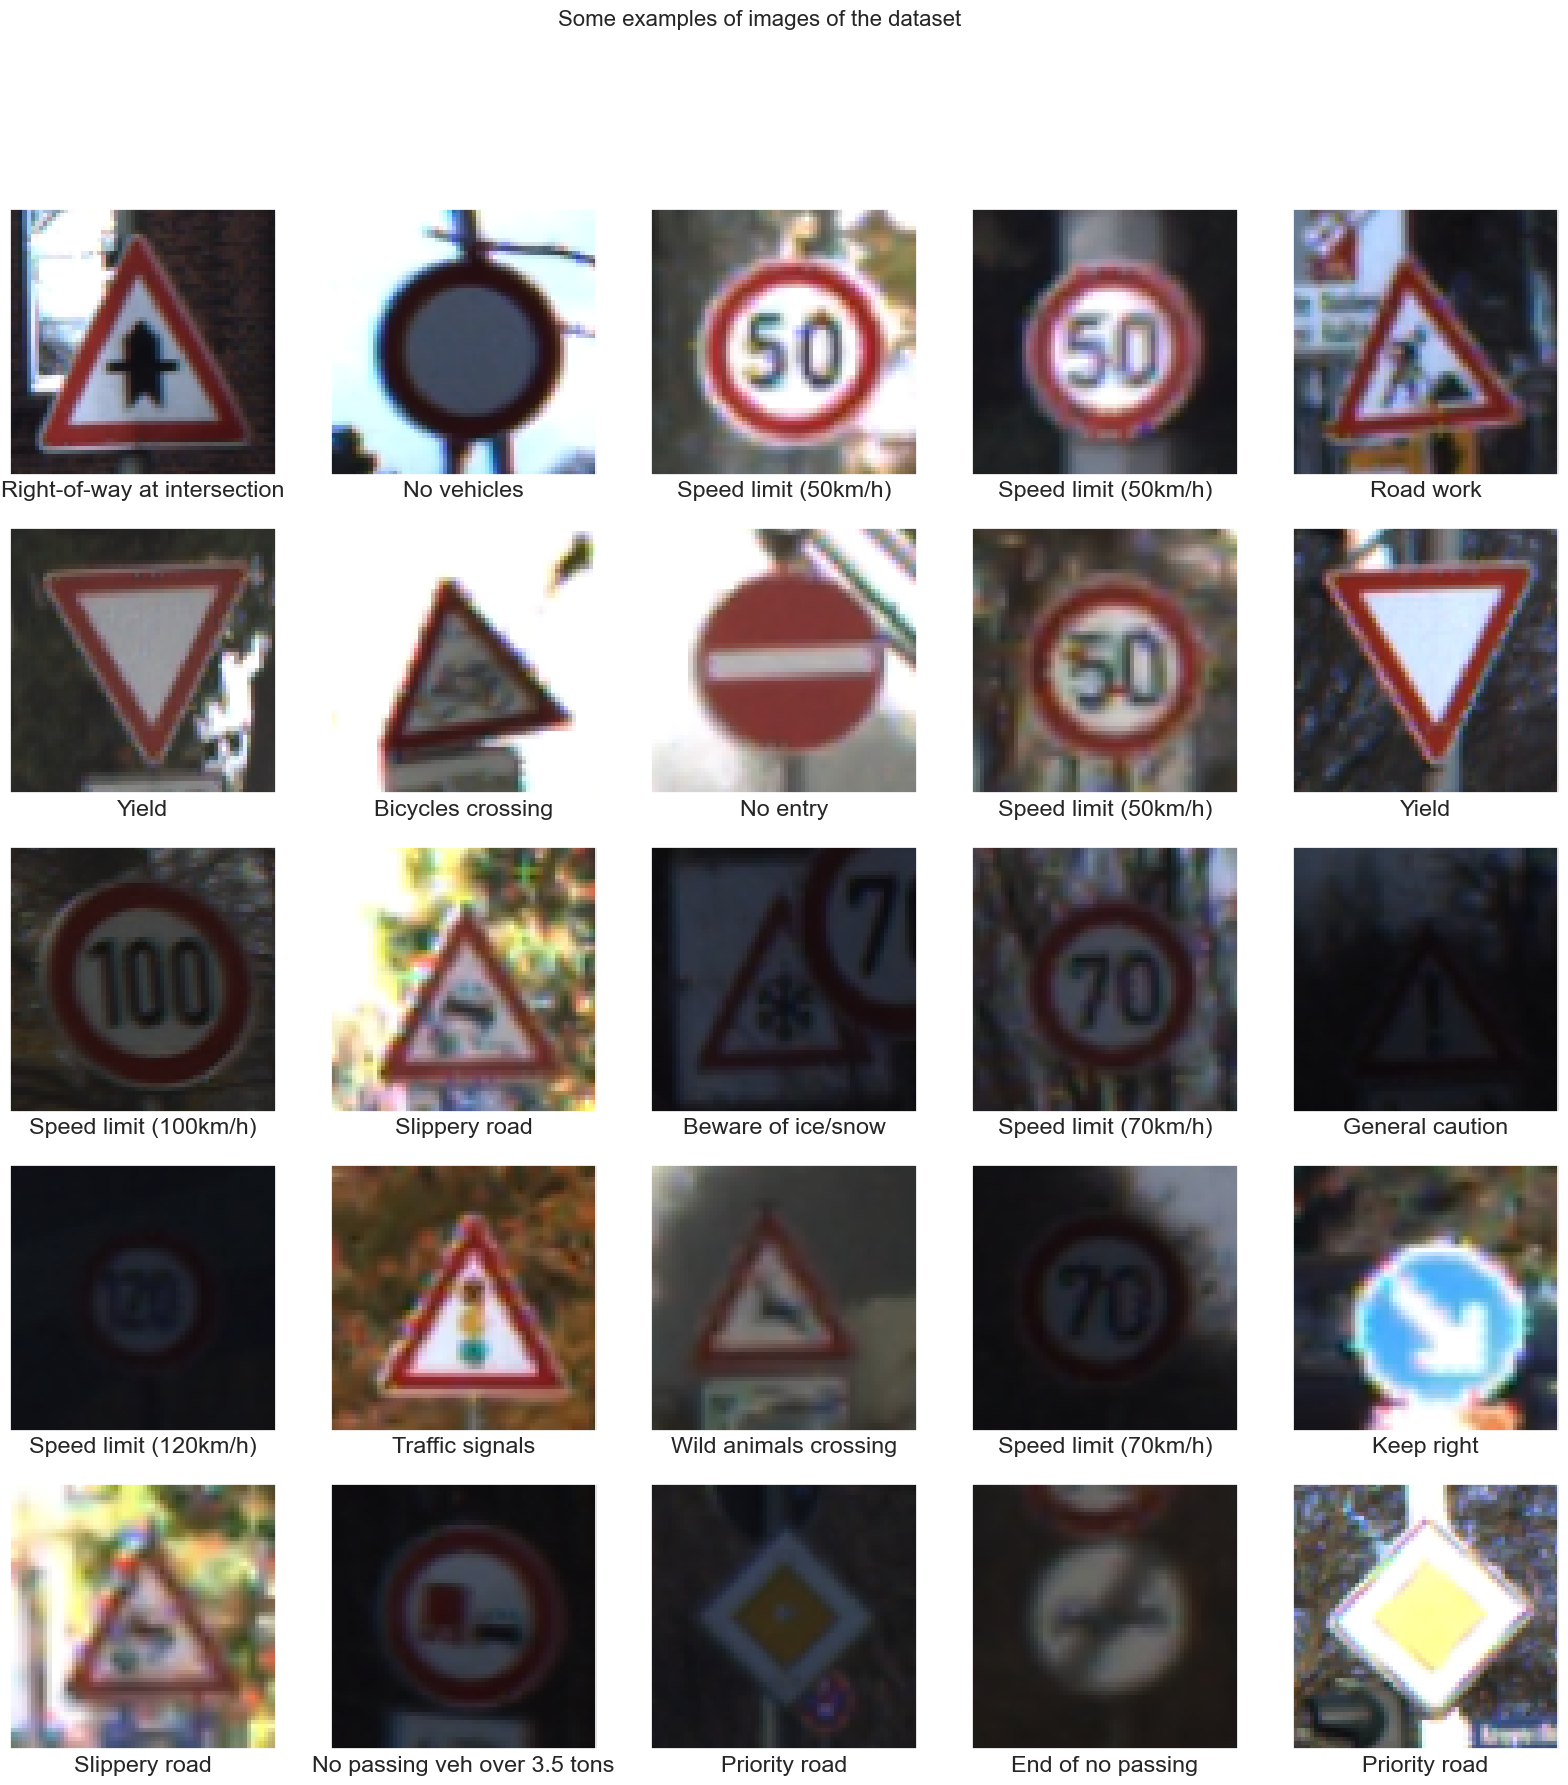

In [18]:
display_examples(classes, train_images, train_labels)

CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=train_images.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,319,659 (73.70 MB)

 Trainable params: 19,319,659 (73.70 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
with tf.device('/GPU:0'):
    epochs = 35
    history1 = model.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_data=(test_images, test_labels))

Epoch 1/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6841 - loss: 1.1419 - val_accuracy: 0.9241 - val_loss: 0.3139
Epoch 2/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.9690 - loss: 0.1113 - val_accuracy: 0.9435 - val_loss: 0.2193
Epoch 3/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9844 - loss: 0.0517 - val_accuracy: 0.9505 - val_loss: 0.2160
Epoch 4/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.9897 - loss: 0.0334 - val_accuracy: 0.9488 - val_loss: 0.2039
Epoch 5/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.9911 - loss: 0.0282 - val_accuracy: 0.9557 - val_loss: 0.2411
Epoch 6/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9936 - loss: 0.0213 - val_accuracy: 0.9618 - val_loss: 0.1792
Epoch 7/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9931 - loss: 0.0231 - val_accuracy: 0.9552 - val_loss: 0.2540
Epoch 8/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9941 - loss: 0.0178 - val_accu

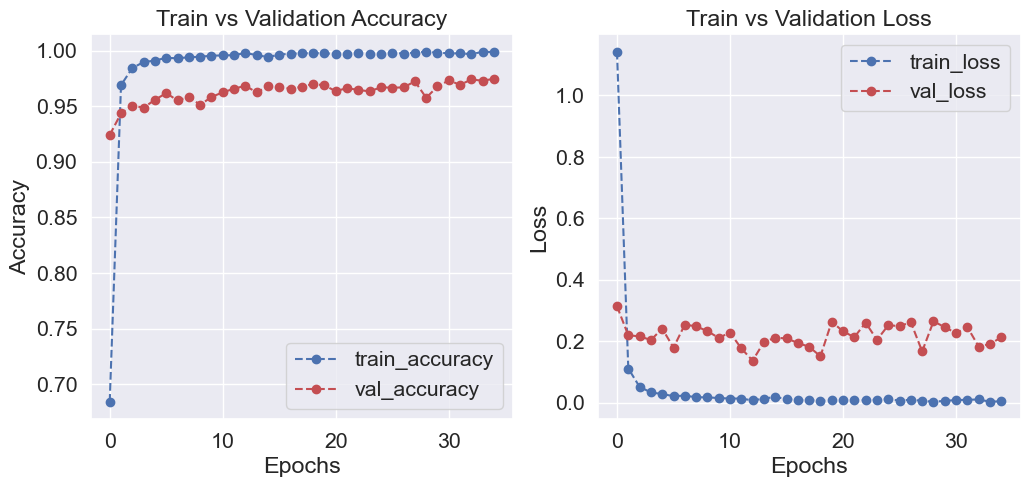

In [ ]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history1.history['accuracy'], 'bo--', label='train_accuracy')
    plt.plot(history1.history['val_accuracy'], 'ro--', label='val_accuracy')
    plt.title("Train vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(1,2,2)
    plt.plot(history1.history['loss'], 'bo--', label='train_loss')
    plt.plot(history1.history['val_loss'], 'ro--', label='val_loss')
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()


plot_accuracy_loss(history1)

Predictions


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


pred_probs = model.predict(test_images)         
pred_labels = np.argmax(pred_probs, axis=1)  

395/395 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step


In [23]:
classes = [str(i) for i in range(43)]

print("Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.98      0.99      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.97      0.98       450
           4       0.99      0.98      0.99       660
           5       0.92      0.99      0.95       630
           6       1.00      0.84      0.91       150
           7       0.98      0.97      0.98       450
           8       0.96      0.98      0.97       450
           9       0.98      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.96      1.00      0.98       420
          12       0.97      0.99      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      0.99       270
          15       0.95      1.00      0.97       210
          16       1.00      0.99      1.00       150
    

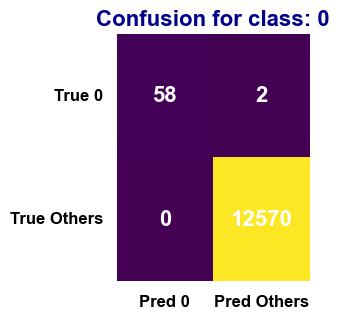

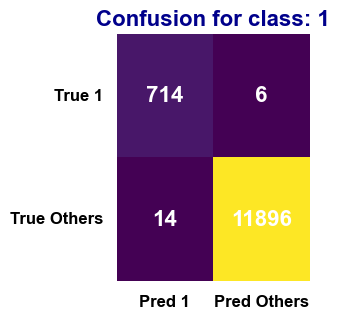

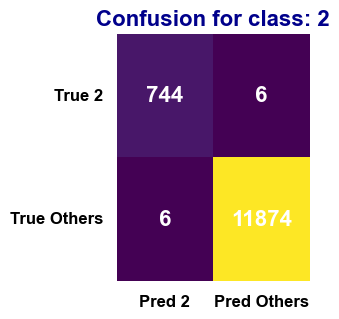

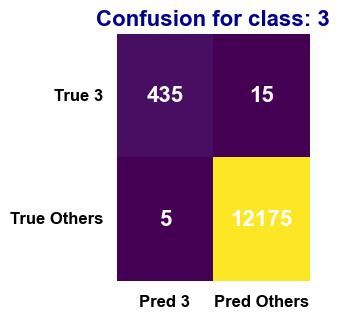

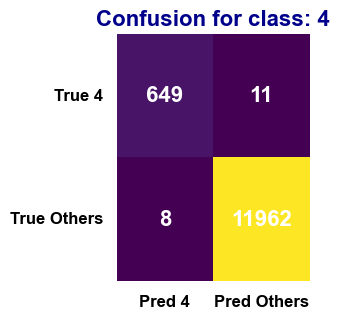

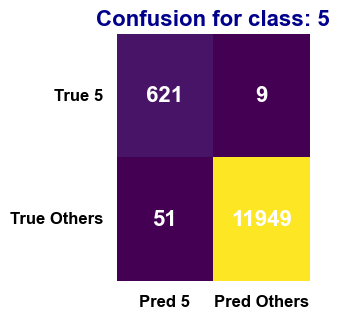

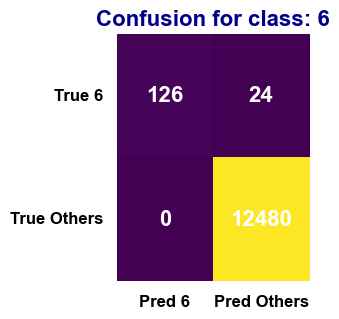

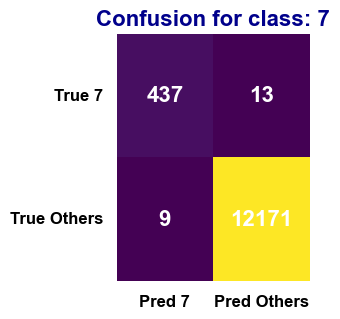

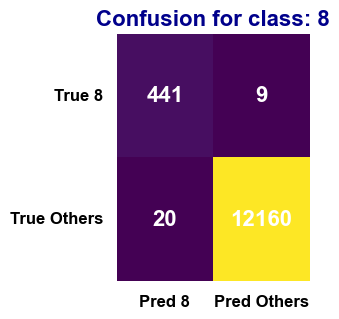

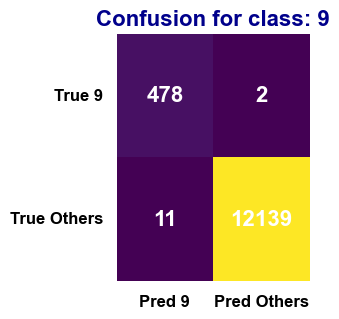

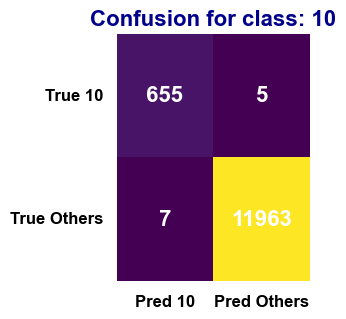

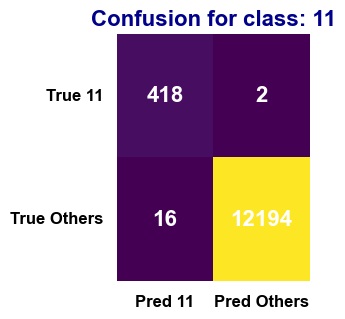

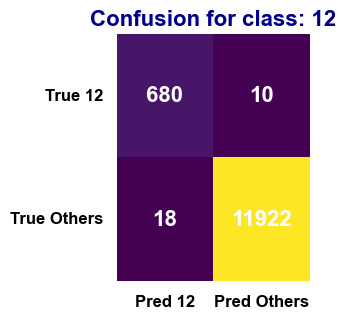

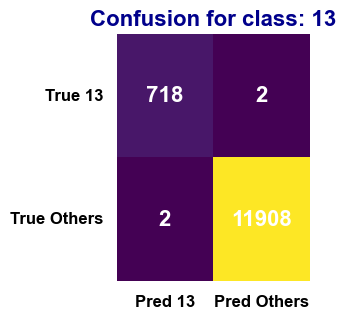

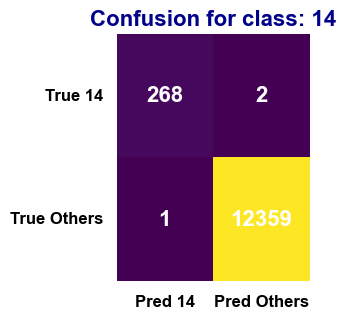

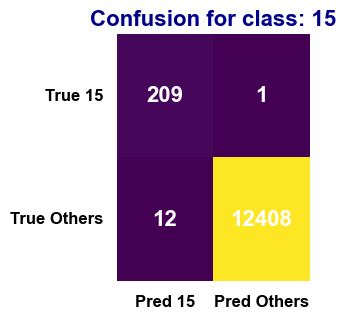

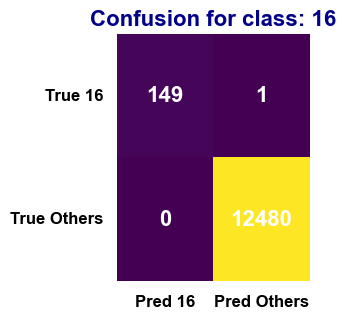

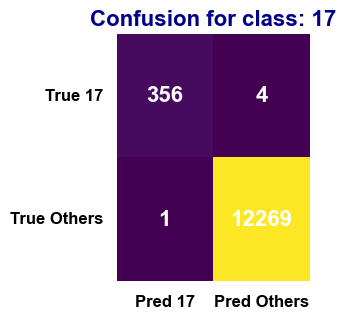

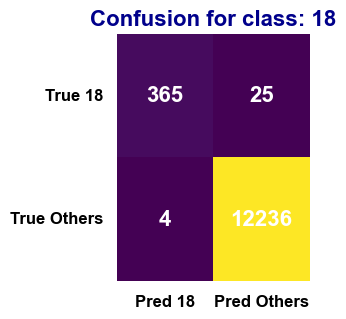

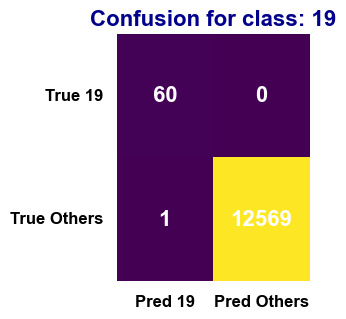

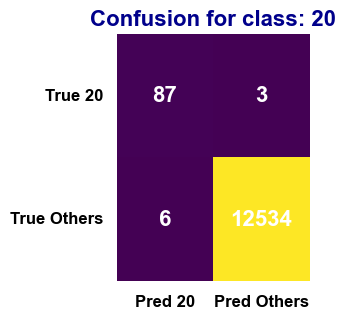

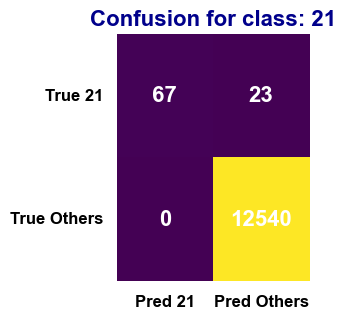

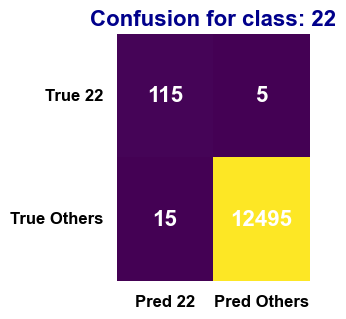

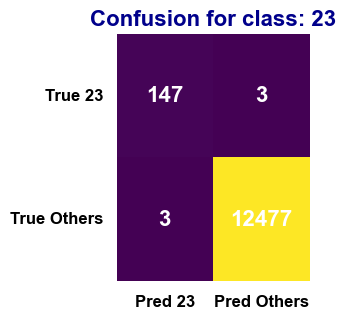

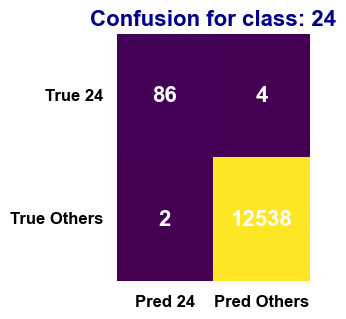

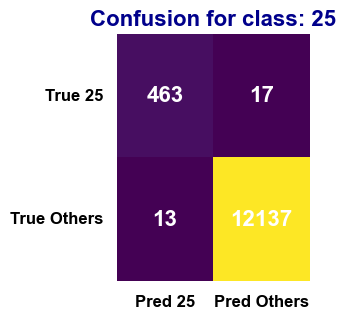

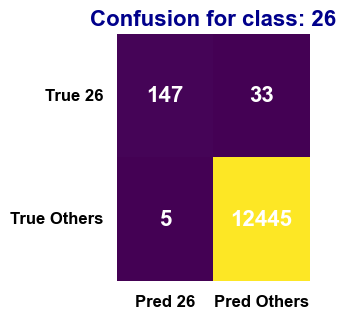

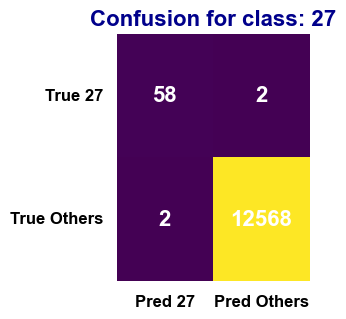

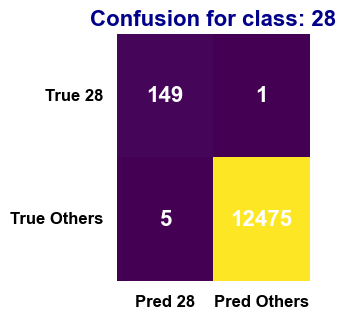

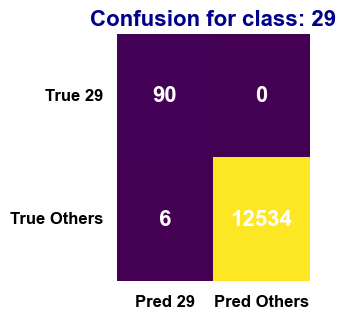

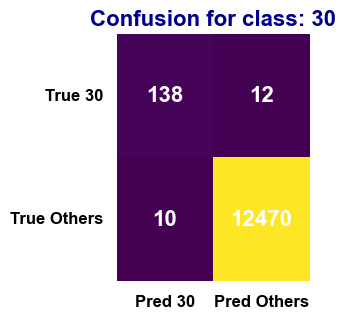

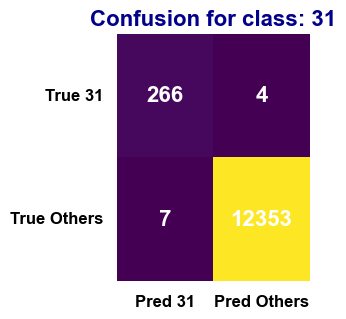

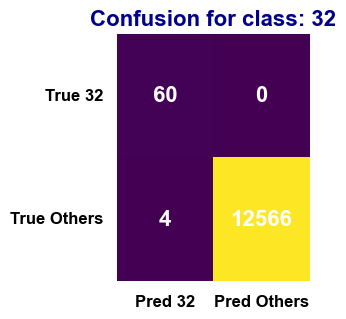

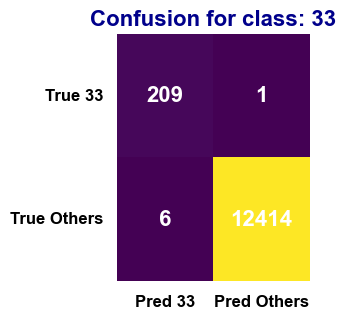

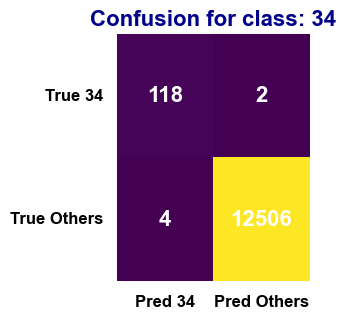

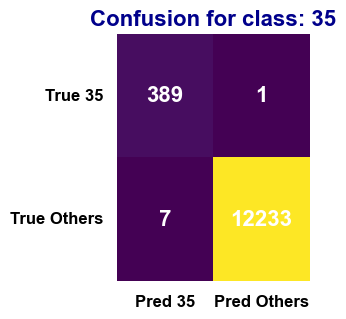

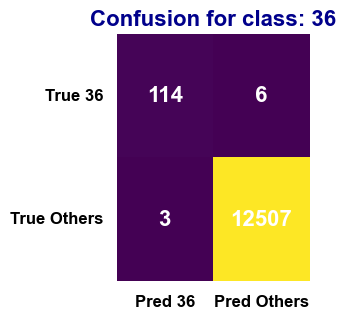

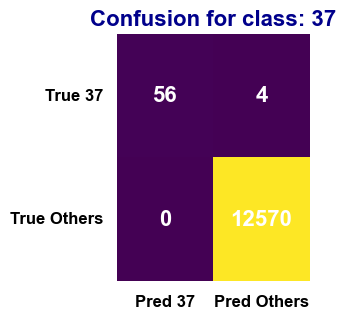

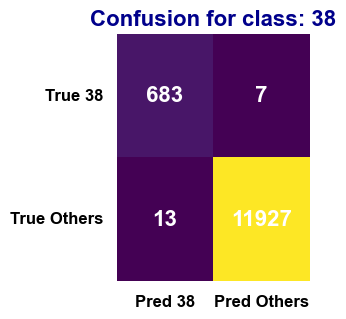

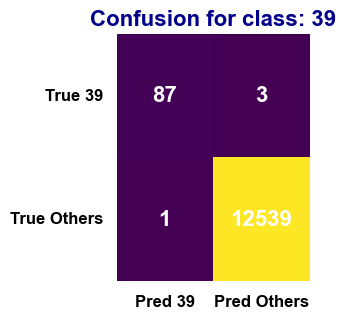

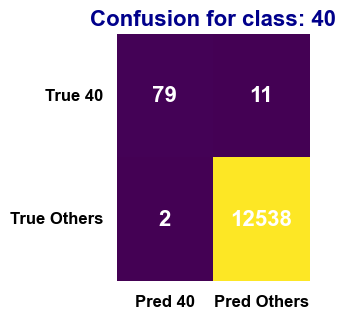

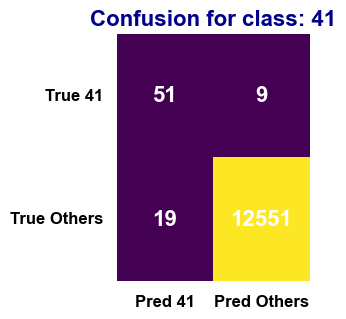

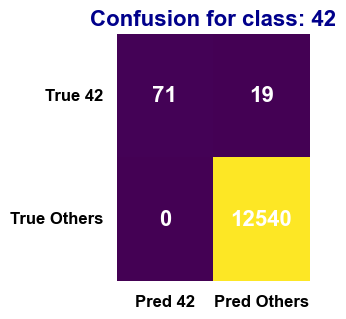

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, pred_labels)

for i, cls in enumerate(classes):
    plt.figure(figsize=(3.5,3.5))
    
   
    cm_class = [[cm[i,i], cm[i].sum() - cm[i,i]],
                [cm[:,i].sum() - cm[i,i], cm.sum() - cm[i].sum() - cm[:,i].sum() + cm[i,i]]]
    
   
    ax = sns.heatmap(cm_class, annot=True, fmt="d", cmap="viridis", cbar=False,
                     xticklabels=[f"Pred {cls}", "Pred Others"],
                     yticklabels=[f"True {cls}", "True Others"],
                     annot_kws={"size":16, "weight":"bold", "color":"white"})  
    
    plt.title(f"Confusion for class: {cls}", fontsize=16, weight="bold", color="darkblue")
    plt.xticks(fontsize=12, weight="bold", color="black")
    plt.yticks(fontsize=12, weight="bold", color="black", rotation=0)
    plt.tight_layout()
    plt.show()

In [25]:
MODEL_SAVE_PATH = r"C:\vs code\AI&ES\Road_sign_2.0.keras"


In [26]:
# Save the entire model (architecture + weights + optimizer state)
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved successfully at: {MODEL_SAVE_PATH}")


✅ Model saved successfully at: C:\vs code\AI&ES\Road_sign_2.0.keras


In [27]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(MODEL_SAVE_PATH)

# Verify
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,958,979 (221.10 MB)

 Trainable params: 19,319,659 (73.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,639,320 (147.40 MB)

In [28]:
model.save("road_sign_2.0.h5")


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# --- Load model ---
MODEL_SAVE_PATH = r"C:\vs code\AI&ES\Road_sign_2.0.keras"
model = load_model(MODEL_SAVE_PATH)

# --- Define classes ---
CLASSES = ['noEntry', 'noParking', 'speedLimit30', 'stop', 'non_sign']

# --- Preprocess test image ---
def preprocess_image(img_path, img_size=64):
    img = cv2.imread(img_path)                # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR → RGB
    img = cv2.resize(img, (img_size, img_size)) # Resize to match training
    img = img / 255.0                          # Normalize
    img = np.expand_dims(img, axis=0)          # Add batch dimension
    return img

# --- Test on new image ---
test_img_path = r"C:\vs code\AI&ES\test_images\sample.jpg"
img = preprocess_image(test_img_path)

prediction = model.predict(img)
pred_class = np.argmax(prediction, axis=1)[0]
print("✅ Predicted Class:", CLASSES[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
✅ Predicted Class: Slippery road


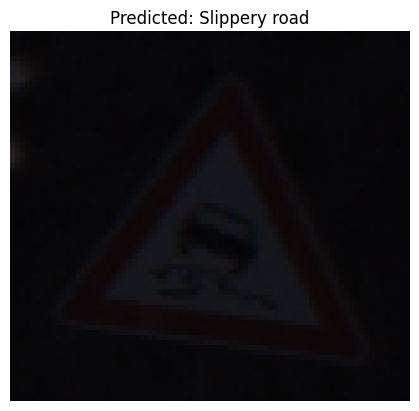

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


MODEL_SAVE_PATH = r"C:\vs code\AI&ES\Road_sign_2.0.keras"
model = load_model(MODEL_SAVE_PATH)


classes = {
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)',
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection',
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
    17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right',
    21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right',
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing',
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing',
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead',
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right',
    39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}


IMG_SIZE = 64 

def preprocess_image(img_path):
    if not os.path.exists(img_path):
        print("⚠️ File not found:", img_path)
        return None
    img = cv2.imread(img_path)
    if img is None:
        print("⚠️ Could not load image:", img_path)
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  
    return img


test_img_path = r"C:\vs code\AI&ES\archive_road\Test\00012.png"
img = preprocess_image(test_img_path)

if img is not None:
    pred_probs = model.predict(img)
    pred_class = np.argmax(pred_probs, axis=1)[0]
    print("✅ Predicted Class:", classes[pred_class])

  
    plt.imshow(cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {classes[pred_class]}")
    plt.axis("off")
    plt.show()


In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


Torch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [21]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define dataset base directory
data_dir = r"C:/vs code/AI&ES/archive_road"

# Load CSV files
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))
test_csv = pd.read_csv(os.path.join(data_dir, "Test.csv"))

# Add full image paths
train_csv['Path'] = train_csv['Path'].apply(lambda x: os.path.join(data_dir, x))
test_csv['Path'] = test_csv['Path'].apply(lambda x: os.path.join(data_dir, x))

# Convert ClassId to string
train_csv['ClassId'] = train_csv['ClassId'].astype(str)

# Split training and validation sets
train_df, val_df = train_test_split(train_csv, test_size=0.2, random_state=42)

# Function to load and preprocess images
def load_images(df, img_size=(48, 48)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row['Path'])
        if img is None:
            continue  # skip missing files
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0  # normalize
        images.append(img)
        labels.append(int(row['ClassId']))
    return np.array(images), np.array(labels)

# Load train and validation data
X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)

# Load test images (if labels available)
if 'ClassId' in test_csv.columns:
    X_test, y_test = load_images(test_csv)
    y_test = to_categorical(y_test, num_classes=43)
else:
    X_test, y_test = load_images(test_csv), None

print("✅ Data loaded successfully!")
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")
if y_test is not None:
    print(f"Test set: {X_test.shape}")


ModuleNotFoundError: No module named 'tensorflow.keras'

In [2]:
pip install tensorflow==2.15.0


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow==2.15.0


In [30]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


AttributeError: module 'tensorflow' has no attribute '__version__'

In [14]:
!pip uninstall tensorflow tensorflow-intel keras keras-preprocessing -y
!pip cache purge


Files removed: 32 (701 kB)


In [2]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


ModuleNotFoundError: No module named 'tensorflow'

In [1]:
pip install tensorflow==2.15.0


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
